UROP codes

In [ ]:
pip install pdpbox

In [ ]:
pip install https://github.com/adebayoj/fairml/archive/master.zip

In [ ]:
!pip install pdpbox

In [ ]:
!pip install eli5

In [ ]:
!pip install Lime

In [ ]:
!pip install Shap

In [ ]:
def clf_metrics(y_pred_train, y_proba_train, y_train, y_pred_test, y_proba_test, y_test):
    """ Generates dataframe with kpis for classification models

        Parameters:
        y_pred_train: model binary train prediction
        y_proba_train: model train probability prediction
        y_train : model true train target values
        y_pred_test: model binary test prediction
        y_proba_train: model  probability test prediction
        y_test : model true test target values

        Returns:
        dataframe  with Accuracy, Precision, Recall, F1, AUC for train and test predictions
       """

    from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, auc, roc_curve
    import pandas as pd
    import matplotlib.pyplot as plt

    y_pred_train = pd.Series(y_pred_train).reset_index(drop=True).copy()
    y_proba_train = pd.Series(y_proba_train).reset_index(drop=True).copy()
    y_train = pd.Series(y_train).reset_index(drop=True).copy()

    y_pred_test = pd.Series(y_pred_test).reset_index(drop=True).copy()
    y_proba_test = pd.Series(y_proba_test).reset_index(drop=True).copy()
    y_test = pd.Series(y_test).reset_index(drop=True).copy()

    fpr_train, tpr_train, threshold_train = roc_curve(y_train, y_proba_train)
    roc_auc_train = auc(fpr_train, tpr_train)

    fpr_test, tpr_test, threshold_test = roc_curve(y_test, y_proba_test)
    roc_auc_test = auc(fpr_test, tpr_test)

    # Results

    train_accuracy = round(accuracy_score(y_train, y_pred_train), 2)
    train_precision = round(precision_score(y_train, y_pred_train), 2)
    train_recall = round(recall_score(y_train, y_pred_train), 2)
    train_f1 = round(f1_score(y_train, y_pred_train), 2)

    test_accuracy = round(accuracy_score(y_test, y_pred_test), 2)
    test_precision = round(precision_score(y_test, y_pred_test), 2)
    test_recall = round(recall_score(y_test, y_pred_test), 2)
    test_f1 = round(f1_score(y_test, y_pred_test), 2)

    train_results = pd.concat([pd.Series(train_accuracy), pd.Series(train_precision), pd.Series(train_recall),
                               pd.Series(train_f1), pd.Series(roc_auc_train)], axis=1)

    test_results = pd.concat([pd.Series(test_accuracy), pd.Series(test_precision), pd.Series(test_recall),
                              pd.Series(test_f1), pd.Series(roc_auc_test)], axis=1)

    results = train_results.append(test_results)
    results.columns = ['Accuracy', 'Precision', 'Recall', 'F1', 'AUC']
    results.index = ['Train', 'Test']

    # Curva ROC
    # Train
    plt.title('TRAIN: ROC Curve')
    plt.plot(fpr_train, tpr_train, 'b', label = 'AUC = %0.2f' % roc_auc_train)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

    # Test

    plt.title('TEST: ROC Curve')
    plt.plot(fpr_test, tpr_test, 'b', label = 'AUC = %0.2f' % roc_auc_test)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

    return results

In [ ]:
# !pip install pandas

import os
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn import tree
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.metrics import r2_score
import eli5
from eli5.sklearn import PermutationImportance
import shap
import lime
from lime import lime_tabular
from lime import submodular_pick
from fairml import audit_model
from fairml import plot_dependencies
# from utils import clf_metrics

%matplotlib inline

In [ ]:
root = '/content/sample_data/adult.csv'
data = pd.read_csv(root, encoding='utf-8')
# Target
data.loc[:, 'income'] = data['income'].apply(lambda x: 0 if x == '<=50K' else 1)
data.head()

age workclass  fnlwgt     education  education.num marital.status  \
0   90         ?   77053       HS-grad              9        Widowed   
1   82   Private  132870       HS-grad              9        Widowed   
2   66         ?  186061  Some-college             10        Widowed   
3   54   Private  140359       7th-8th              4       Divorced   
4   41   Private  264663  Some-college             10      Separated   

          occupation   relationship   race     sex  capital.gain  \
0                  ?  Not-in-family  White  Female             0   
1    Exec-managerial  Not-in-family  White  Female             0   
2                  ?      Unmarried  Black  Female             0   
3  Machine-op-inspct      Unmarried  White  Female             0   
4     Prof-specialty      Own-child  White  Female             0   

   capital.loss  hours.per.week native.country  income  
0          4356              40  United-States       0  
1          4356              18  United-States       0  
2          4356              40  United-States       0  
3          3900              40  United-States       0  
4          3900              40  United-States       0

In [ ]:
# Workclass
data["workclass"] = data["workclass"].replace(["?"],'Unknown')
# Marital status
data["marital.status"] = data["marital.status"].replace(['Married-civ-spouse','Married-spouse-absent','Married-AF-spouse'], 1)
data["marital.status"] = data["marital.status"].replace(['Never-married','Divorced','Separated','Widowed'], 0)
# Native country
data['native.country'] = data["native.country"].replace(["?"],'Unknown')


In [ ]:
colNum = ['age','fnlwgt','education.num','capital.gain','capital.loss','hours.per.week', 'income']

data_model = pd.concat([data[colNum],
                        pd.get_dummies(data['workclass'], drop_first = True, prefix = 'class'),
                        pd.get_dummies(data['marital.status'], drop_first = True, prefix = 'married'),
                        pd.get_dummies(data['native.country'], drop_first = True, prefix = 'nac'),
                        pd.get_dummies(data['relationship'], drop_first = True, prefix = 'rel'),
                        pd.get_dummies(data['race'], drop_first = True, prefix = 'race'),
                        pd.get_dummies(data['sex'], drop_first = True, prefix = 'sex'),
                          ], axis = 1)

In [ ]:
## Train/Test Split
target_col = 'income'
X_train, X_test, y_train, y_test = train_test_split(data_model.drop(target_col, axis=1),
                                                    data_model[target_col],
                                                    shuffle=True, random_state=2003, test_size=0.54)

In [ ]:
clf_xgb_df = xgb.XGBClassifier(objective = 'binary:logistic', n_estimators= 800, max_depth= 9,
                              learning_rate= 0.005, seed = 2003)

clf_xgb_df.fit(X_train, y_train, eval_metric="auc", verbose=False)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.005, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=9, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=800, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [ ]:
clf_xgb_array = xgb.XGBClassifier(objective = 'binary:logistic', n_estimators= 800, max_depth= 9,
                              learning_rate= 0.005, seed = 2003)

clf_xgb_array.fit(X_train.values, y_train, eval_metric="auc", verbose=False)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.005, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=9, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=800, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [ ]:
y_pred_train = clf_xgb_df.predict(X_train)
y_proba_train = clf_xgb_df.predict_proba(X_train)[:, 1]
y_pred_test = clf_xgb_df.predict(X_test)
y_proba_test = clf_xgb_df.predict_proba(X_test)[:, 1]

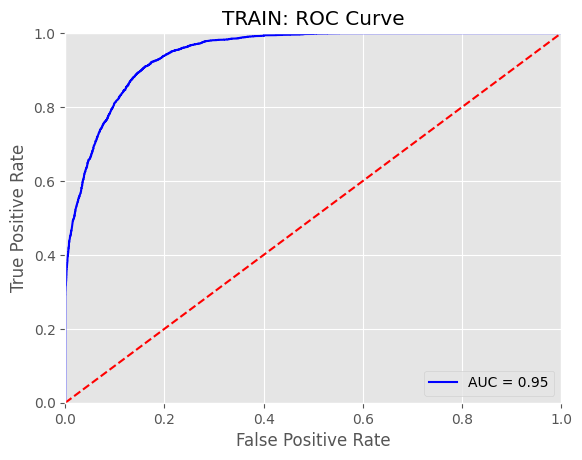

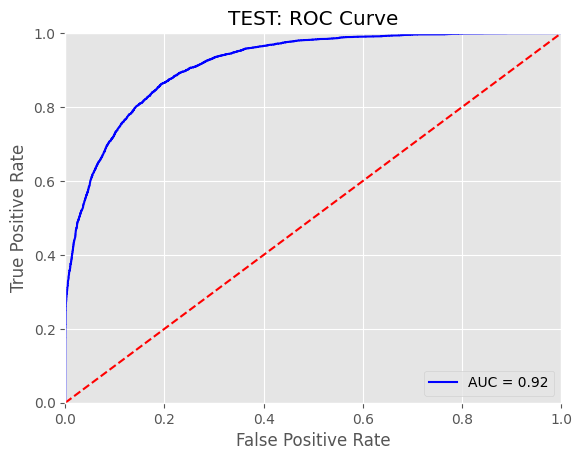

Accuracy  Precision  Recall    F1       AUC
Train      0.88       0.82    0.65  0.73  0.947153
Test       0.87       0.78    0.62  0.69  0.917477

In [ ]:
clf_metrics(y_pred_train, y_proba_train, y_train, y_pred_test, y_proba_test, y_test)


some other stuffs

<Axes: >

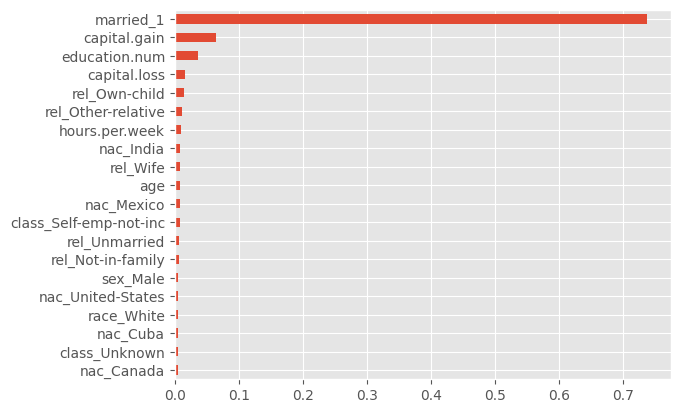

In [ ]:
feat_importances = pd.Series(clf_xgb_df.feature_importances_, index = X_train.columns).sort_values(ascending=True)
feat_importances.tail(20).plot(kind='barh')

In [ ]:
explainer = shap.TreeExplainer(clf_xgb_df)
shap_values = explainer.shap_values(X_test)

# shap.summary_plot(shap_values, X_test, plot_type = 'chart')

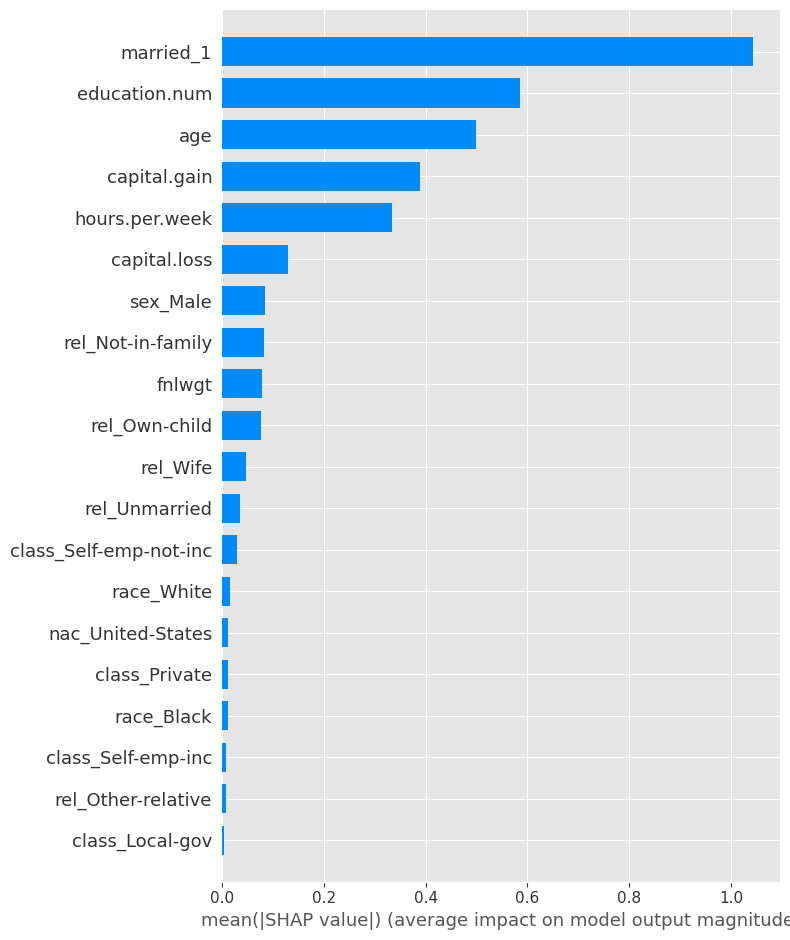

In [ ]:
 shap.summary_plot(shap_values, X_test, plot_type = 'bar')

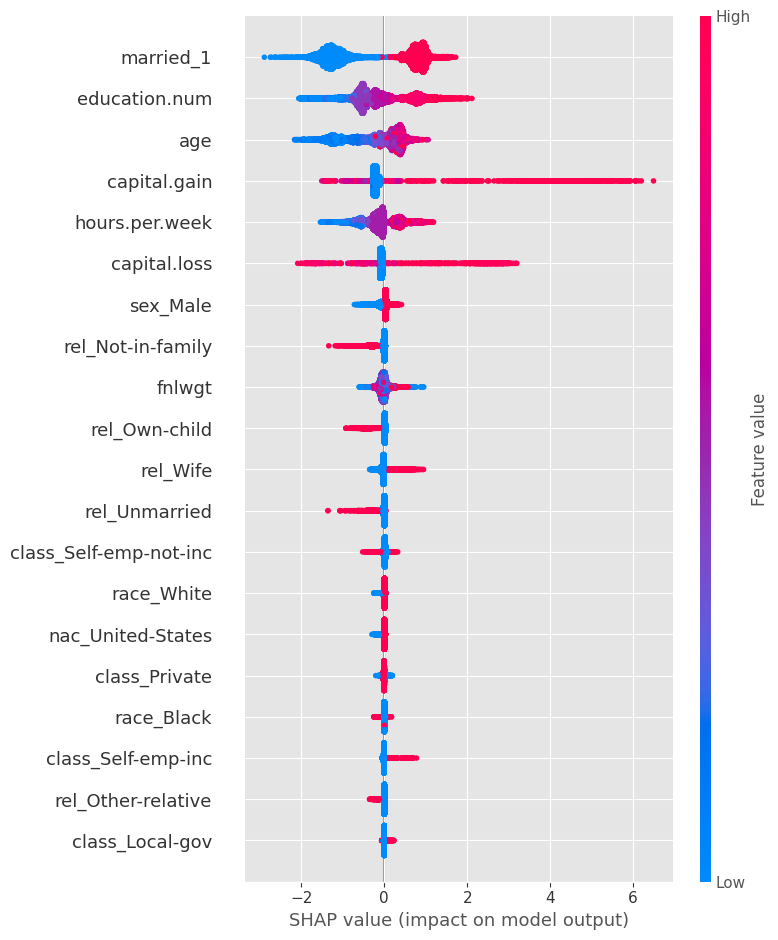

In [ ]:
shap.summary_plot(shap_values, X_test)

Global Training Stuffs

In [ ]:
perm = PermutationImportance(clf_xgb_df, scoring = 'roc_auc', random_state=2003).fit(X_train, y_train)
eli5.show_weights(perm, feature_names = X_train.columns.tolist())

In [ ]:
perm = PermutationImportance(clf_xgb_df, scoring = 'roc_auc', random_state=2003).fit(X_test, y_test)
eli5.show_weights(perm, feature_names = X_test.columns.tolist())

Pdp stuffs here:

Here, SHAP Stuffs

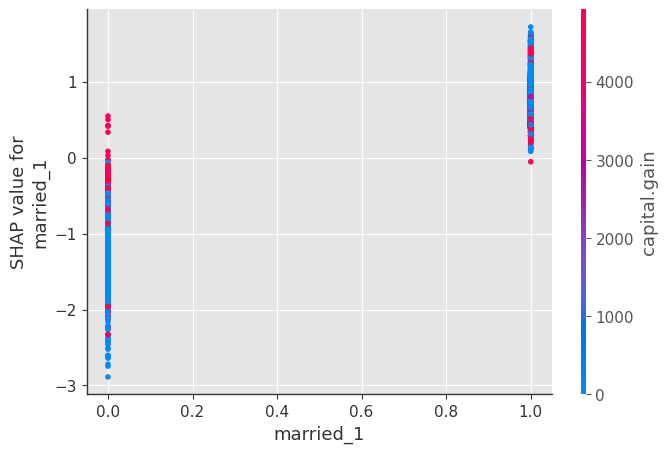

In [ ]:
shap.dependence_plot('married_1', shap_values, X_test)


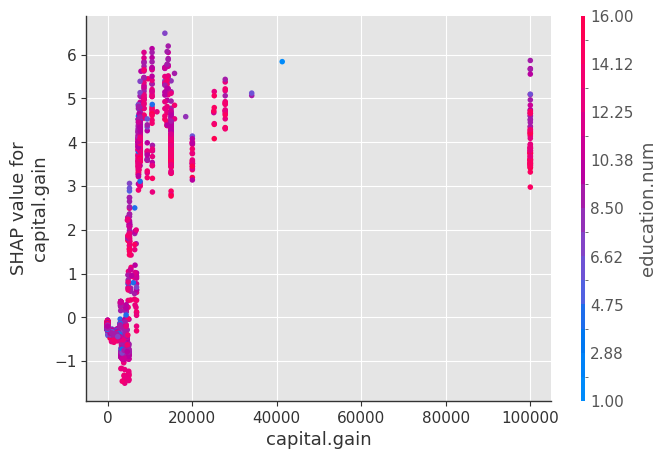

In [ ]:
shap.dependence_plot('capital.gain', shap_values, X_test)

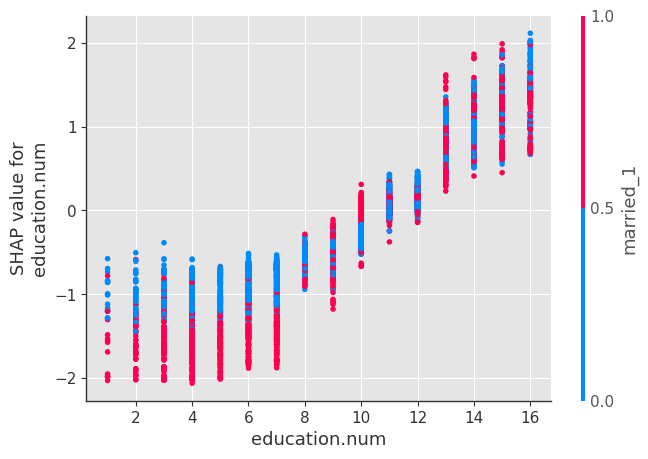

In [ ]:
shap.dependence_plot('education.num', shap_values, X_test)


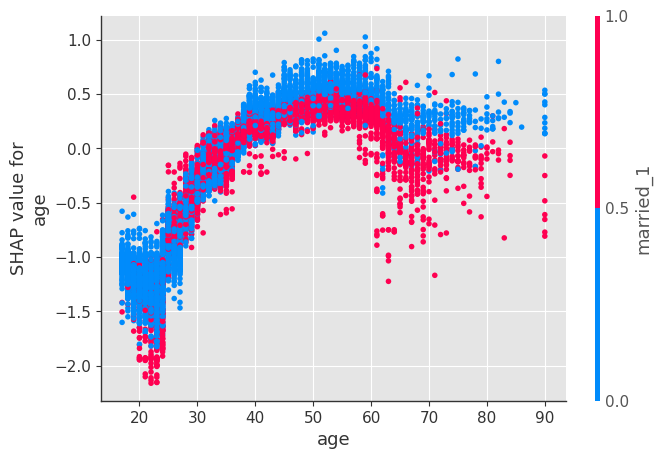

In [ ]:
shap.dependence_plot('age', shap_values, X_test)


Global Surrogate Model

In [ ]:
log_clf = LogisticRegression().fit(X_train, y_train)
y_pred_train_log = log_clf.predict(X_train)
y_proba_train_log = log_clf.predict_proba(X_train)[:, 1]
y_pred_test_log = log_clf.predict(X_test)
y_proba_test_log = log_clf.predict_proba(X_test)[:, 1]

In [ ]:
print('R-squared Train RL-XGB: ', r2_score(y_proba_train_log, y_proba_train))
print('R-squared Test RL-XGB: ', r2_score(y_proba_test_log, y_proba_test))

R-squared Train RL-XGB:  -1.4060793163106124
R-squared Test RL-XGB:  -1.4276101337818754


This is enough:  R-squared is negative for both Train and Test sets. This happens when the fit is worse than simply using the mean. Therefore, it is concluded that Logistic Regression is not a good surrogate model.

In [ ]:
tree_clf = tree.DecisionTreeClassifier(random_state=0, max_depth=4).fit(X_train, y_train)

In [ ]:
y_pred_train_tr = tree_clf.predict(X_train)
y_proba_train_tr = tree_clf.predict_proba(X_train)[:, 1]
y_pred_test_tr = tree_clf.predict(X_test)
y_proba_test_tr = tree_clf.predict_proba(X_test)[:, 1]

R-squared Train DT-XGB:  0.7729464293602677
R-squared Test DT-XGB:  0.7984255434501591


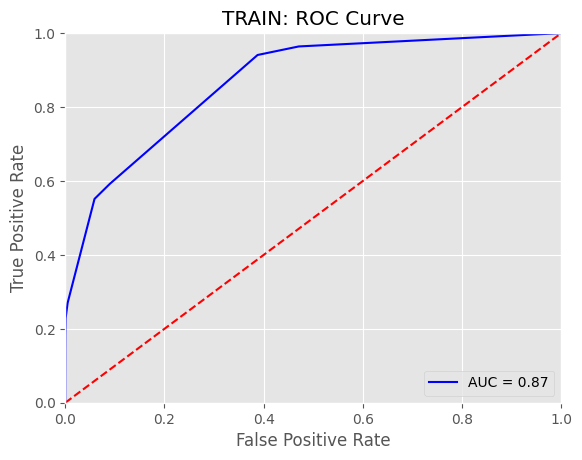

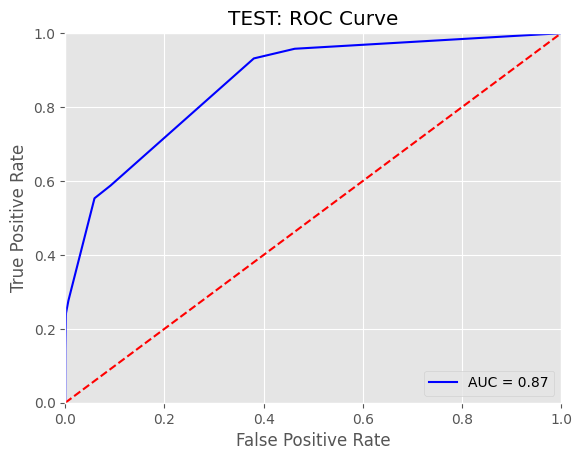

Accuracy  Precision  Recall    F1       AUC
Train      0.85       0.75    0.55  0.64  0.868197
Test       0.85       0.75    0.55  0.64  0.865062

In [ ]:

print('R-squared Train DT-XGB: ', r2_score(y_proba_train_tr, y_proba_train))
print('R-squared Test DT-XGB: ', r2_score(y_proba_test_tr, y_proba_test))

## Metricas
clf_metrics(y_pred_train_tr, y_proba_train_tr, y_train, y_pred_test_tr, y_proba_test_tr, y_test)

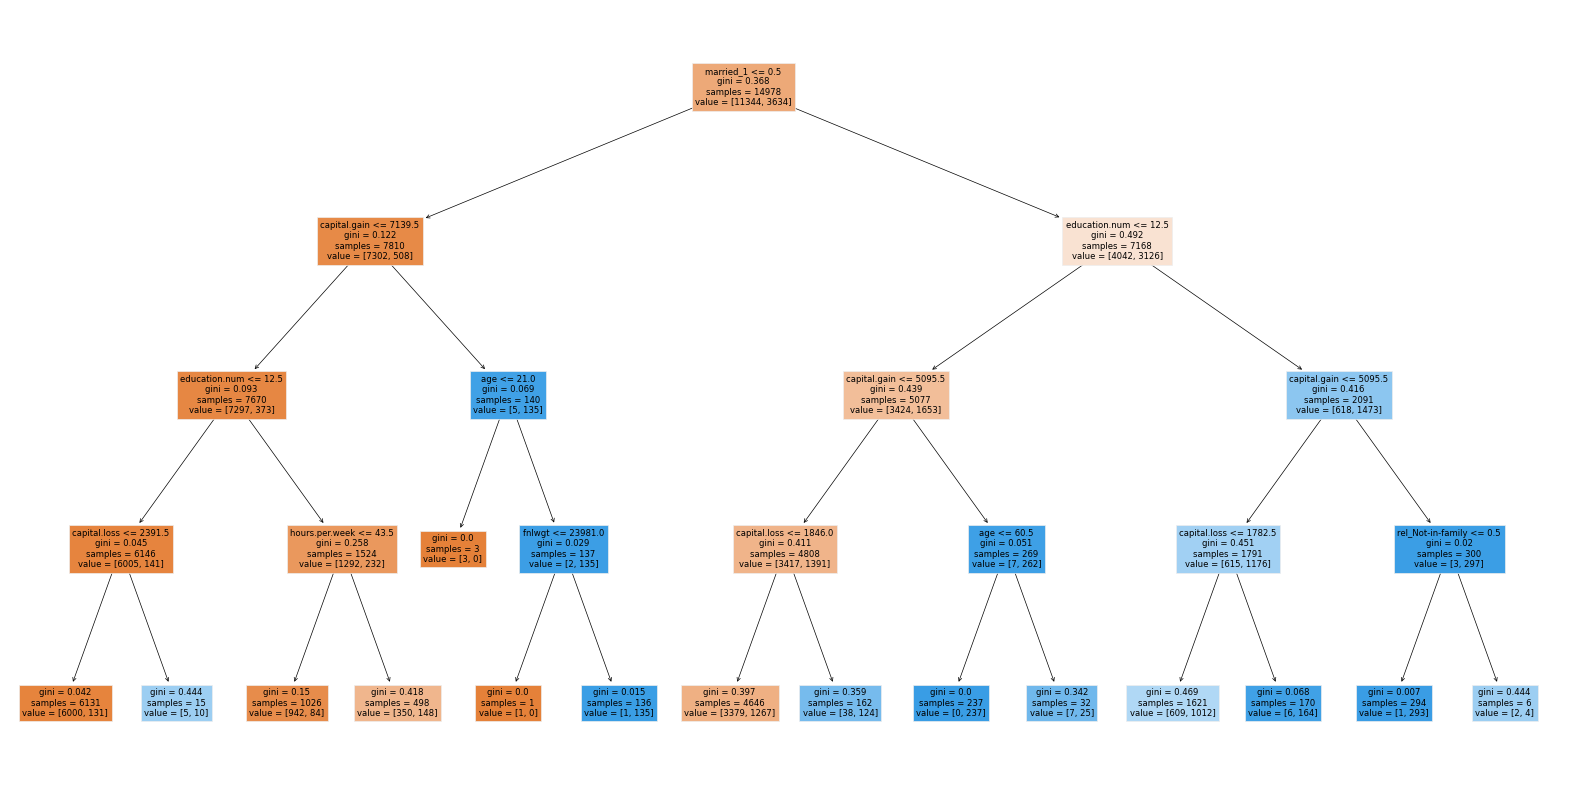

In [ ]:
fig, ax = plt.subplots(figsize=(20, 10))
tree.plot_tree(tree_clf, feature_names= X_train.columns.to_list(), ax=ax, filled=True)
plt.show()

Now, LIME Stuff

In [ ]:
explainer = lime.lime_tabular.LimeTabularExplainer(X_train.values, mode='classification',
                                                   feature_names=X_train.columns.tolist(),
                                                   discretize_continuous=False, random_state=2003)

Give some instance (an integer from the domain): 12


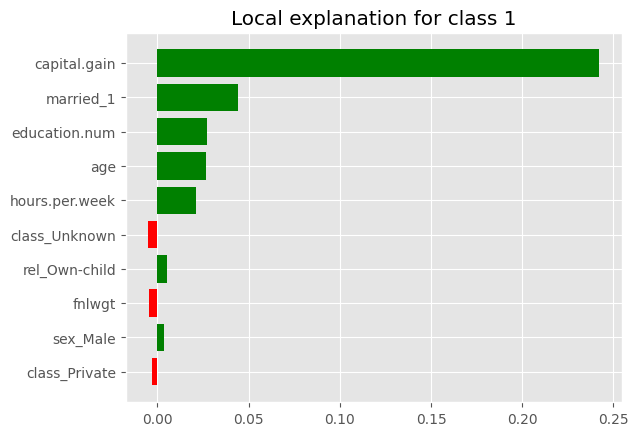

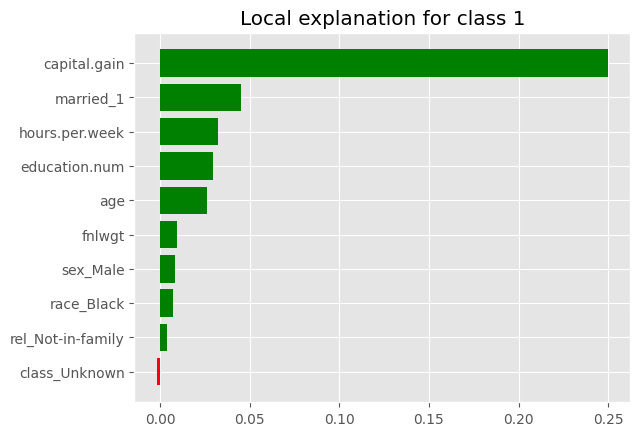

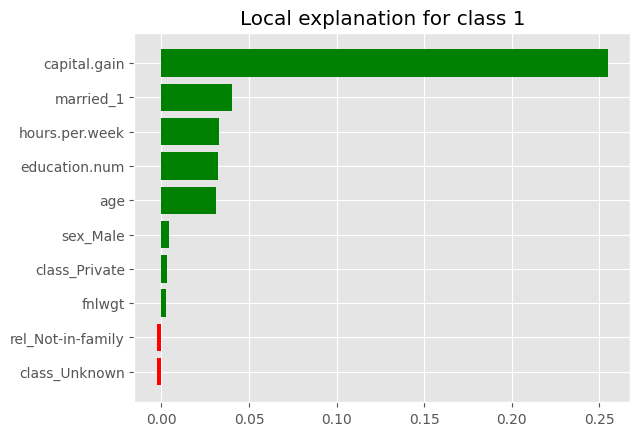

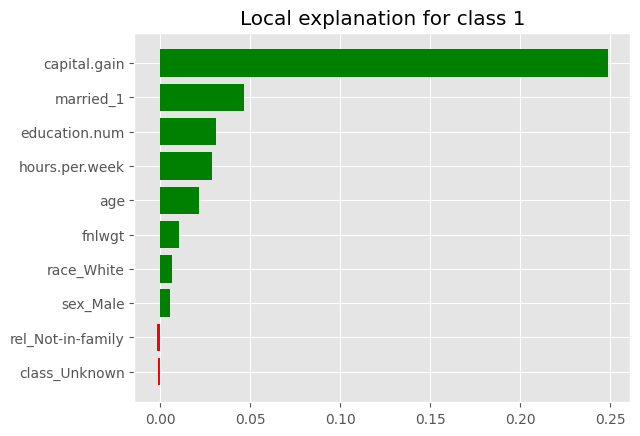

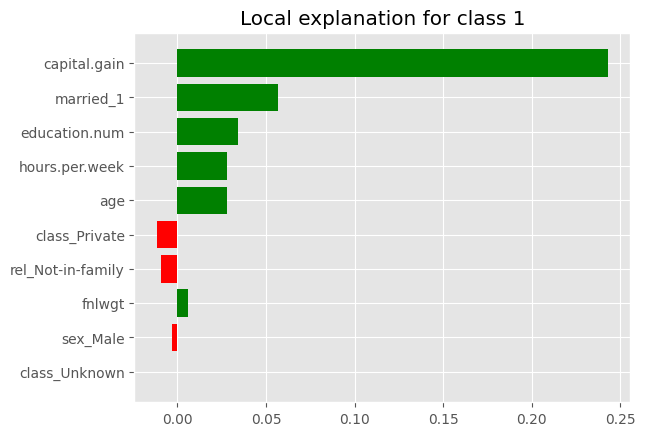

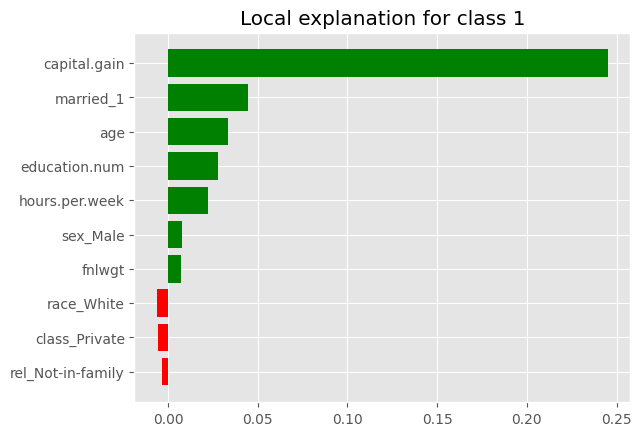

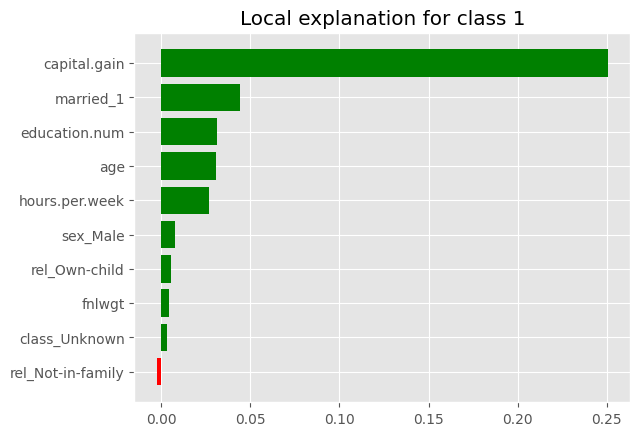

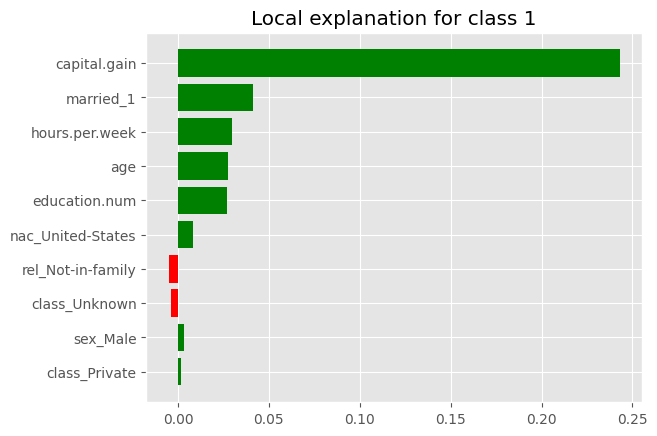

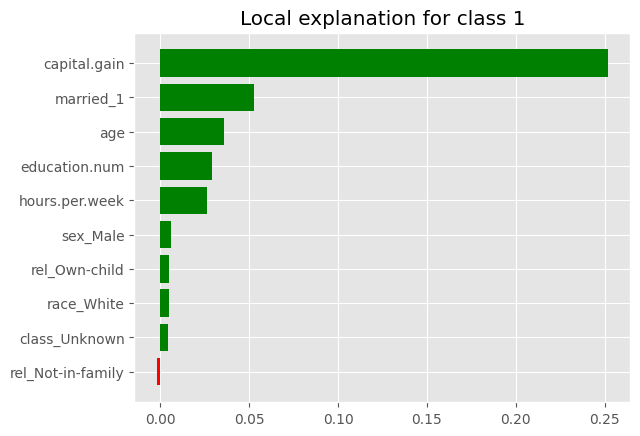

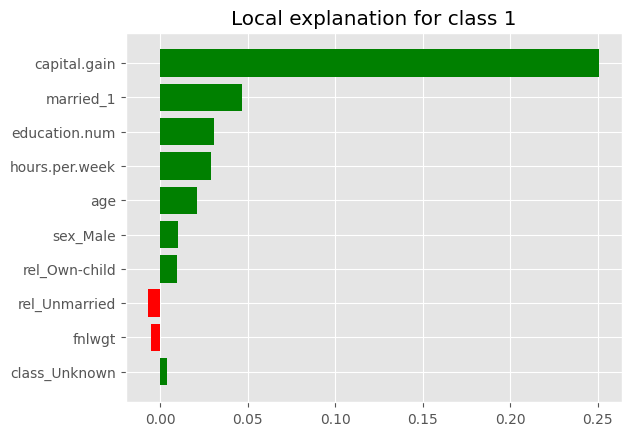

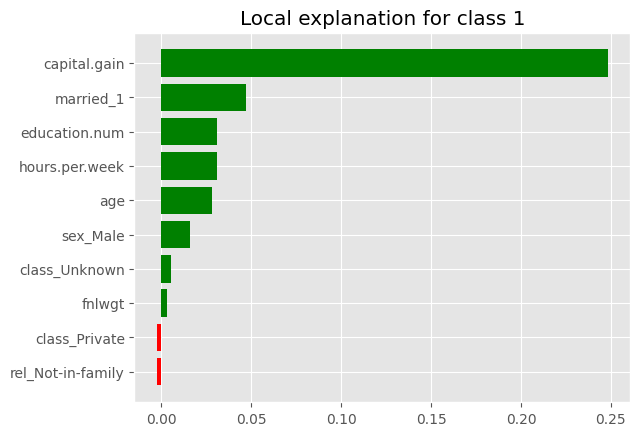

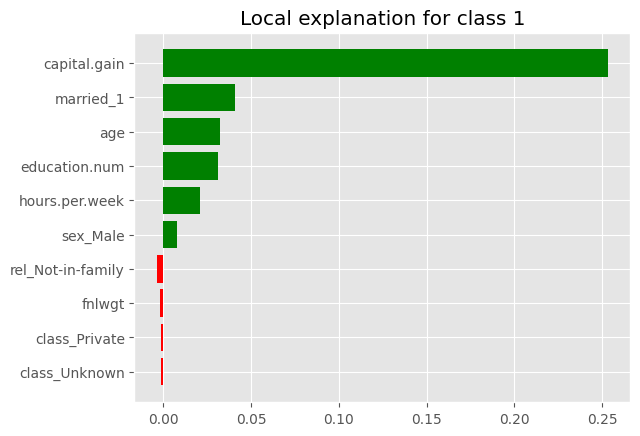

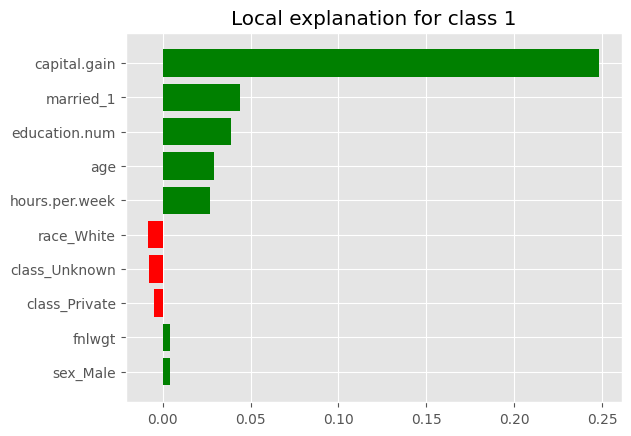

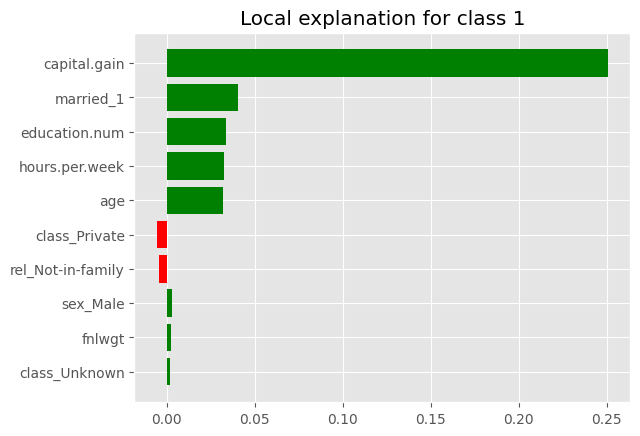

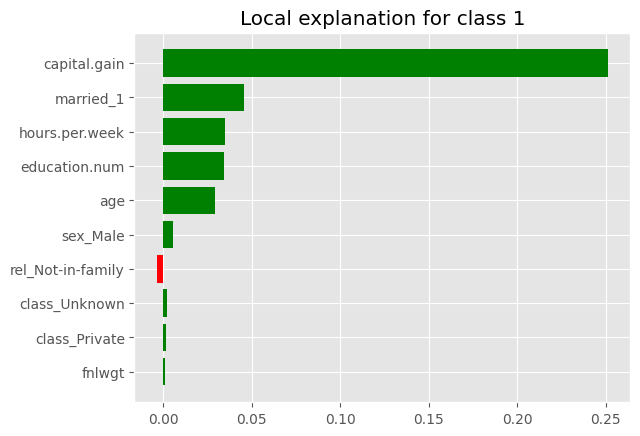

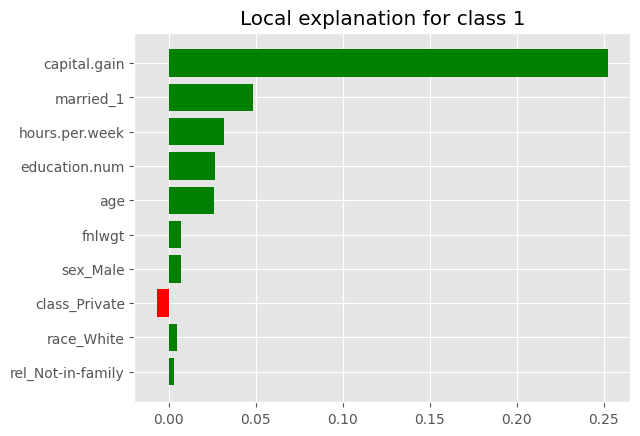

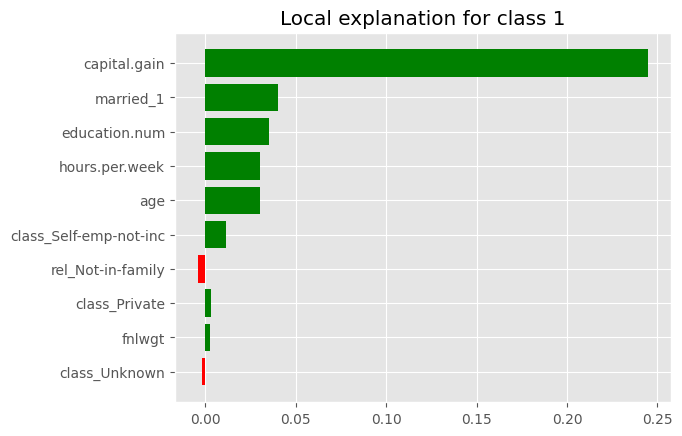

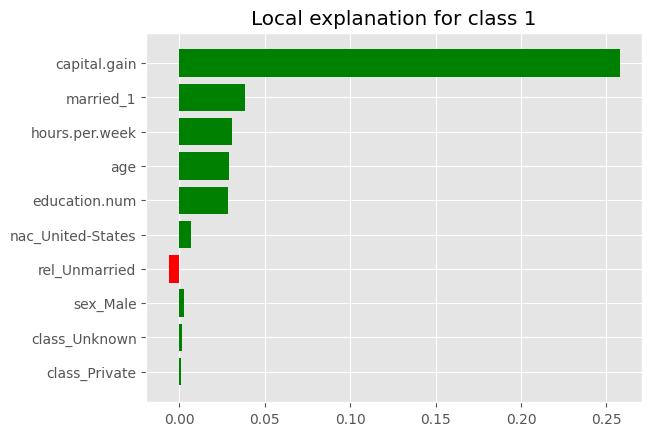

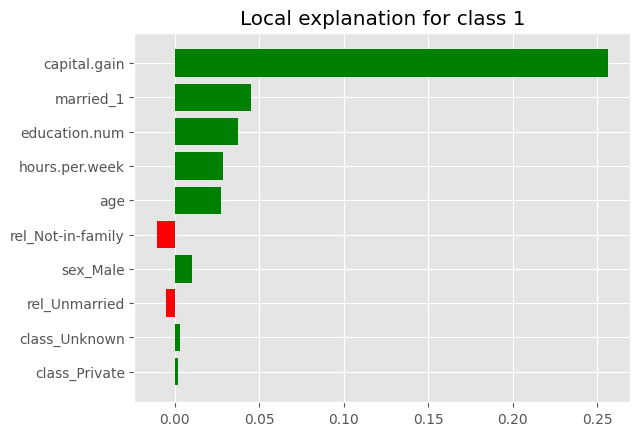

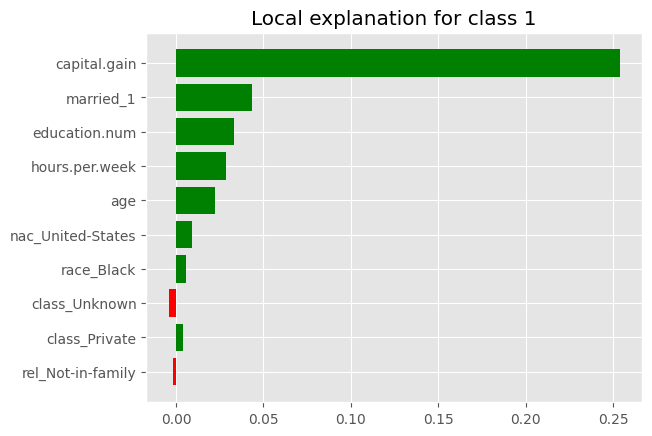

In [ ]:
i = input("Give some instance (an integer from the domain): ")
i = int(i)

for _ in range(20):
    exp = explainer.explain_instance(X_test.values[i], clf_xgb_array.predict_proba)

    %matplotlib inline
    fig = exp.as_pyplot_figure()
    plt.show()

Give some instance (an integer from the domain): 211


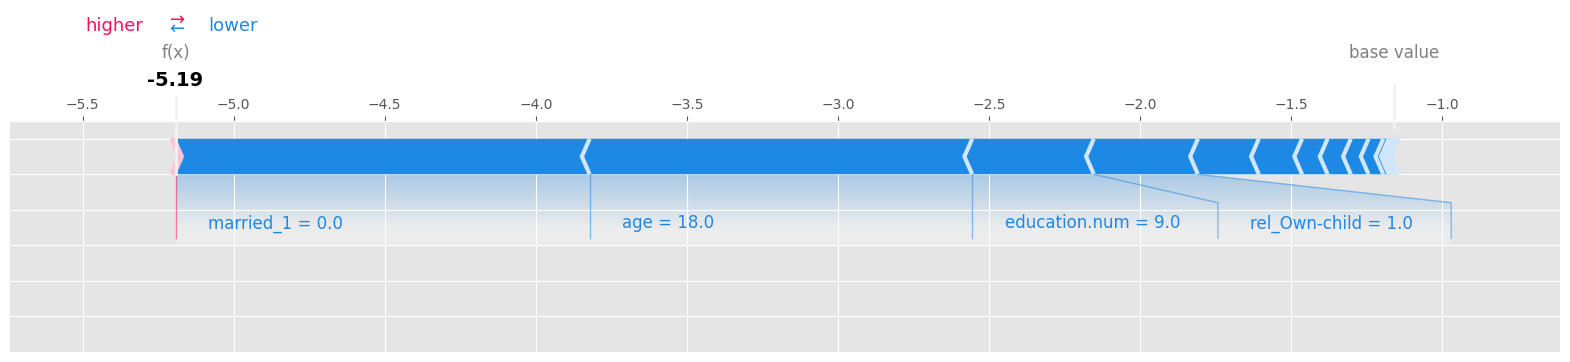

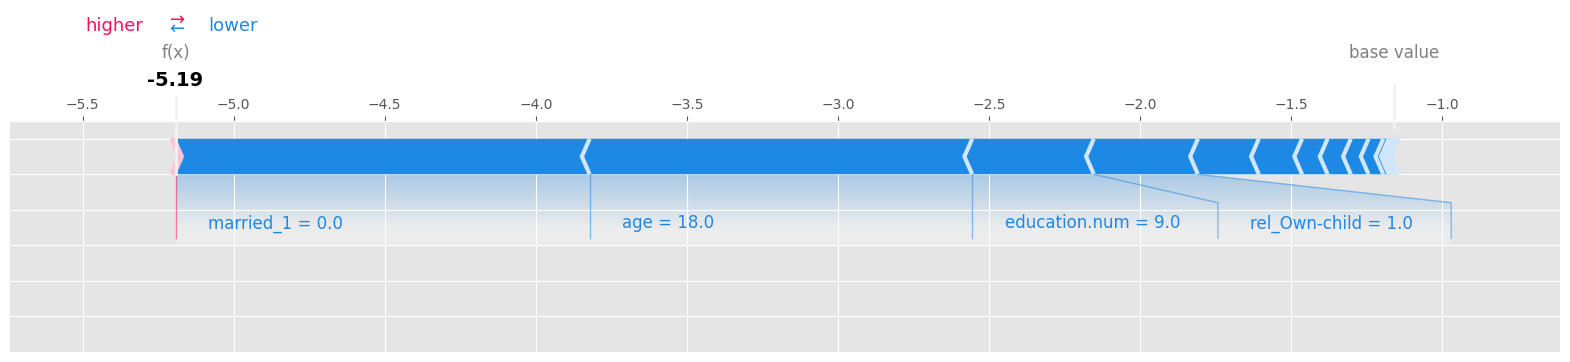

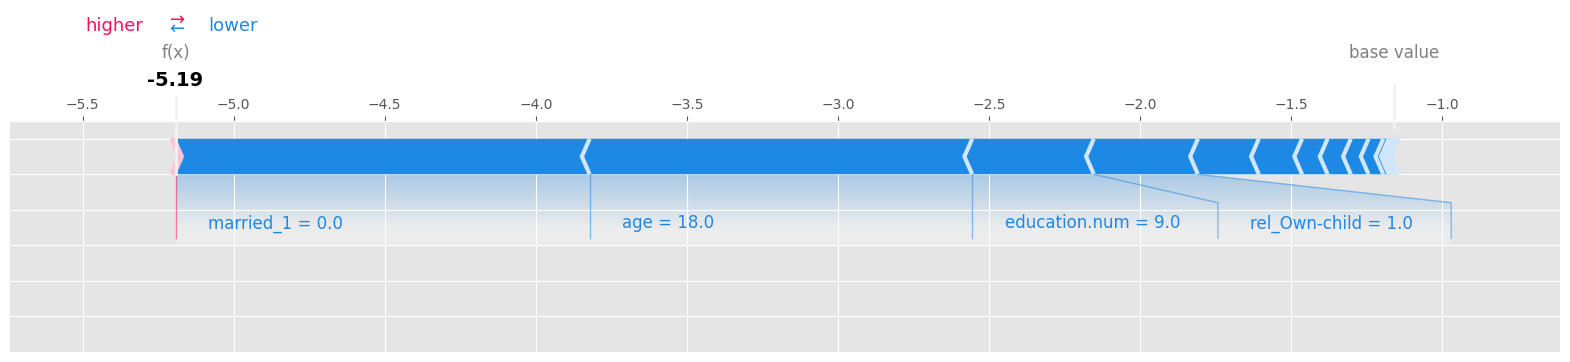

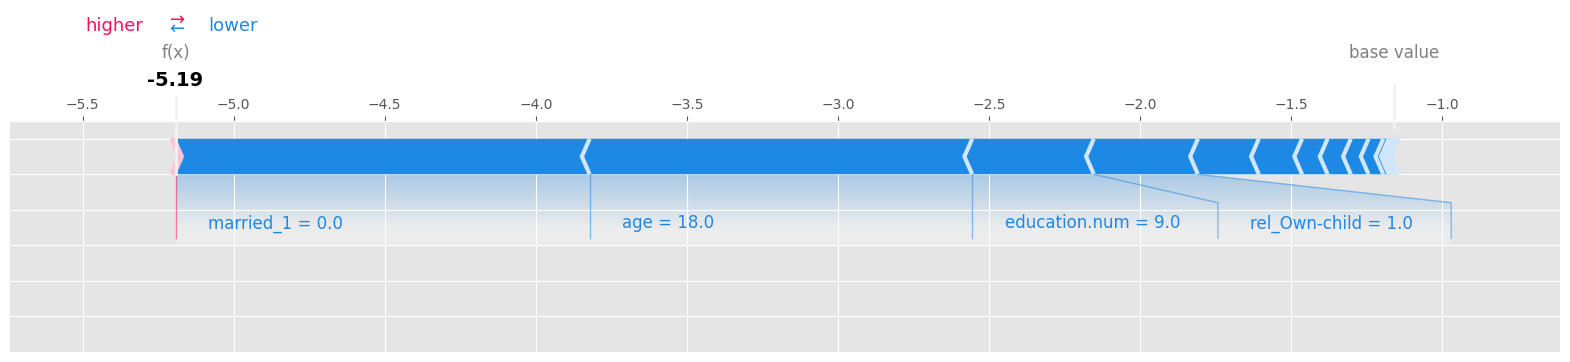

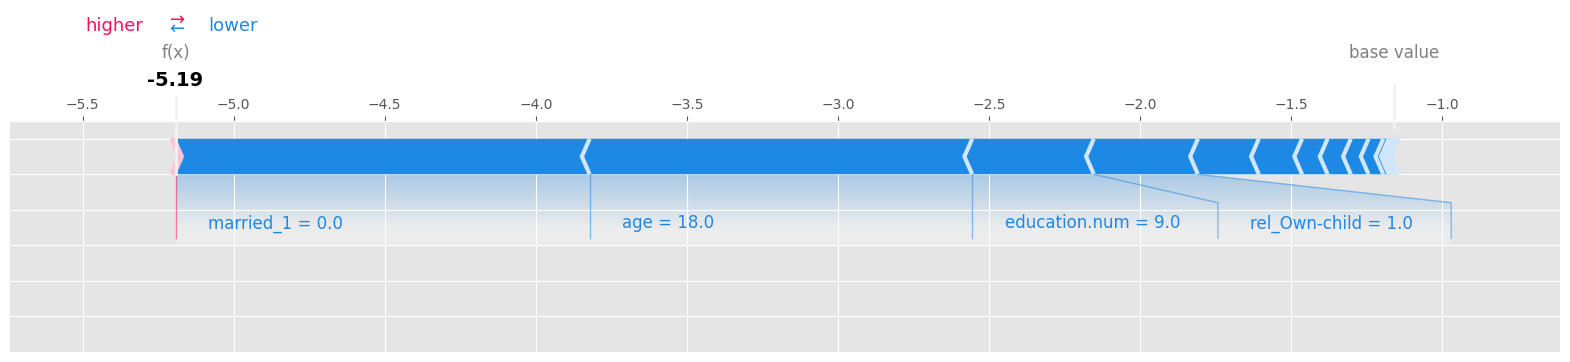

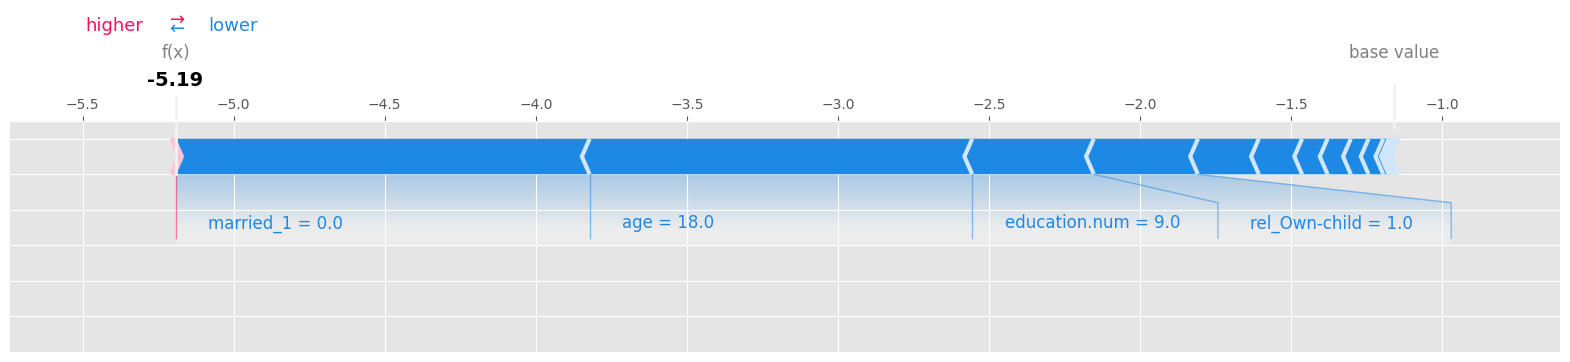

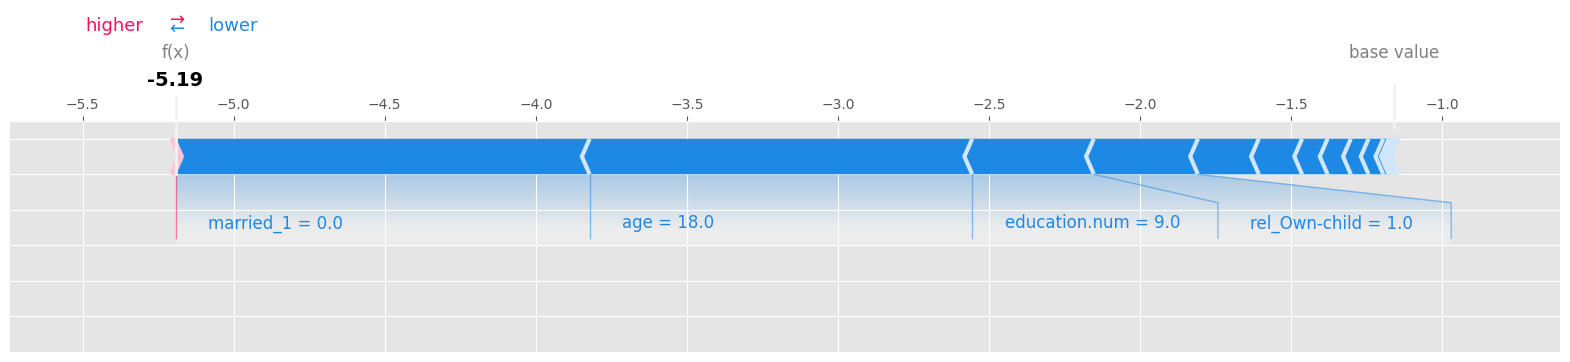

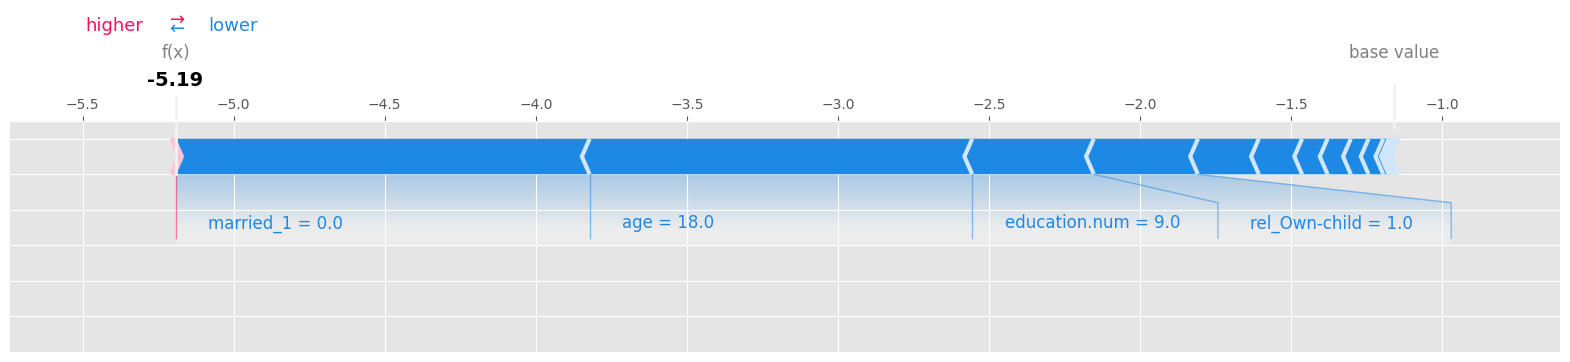

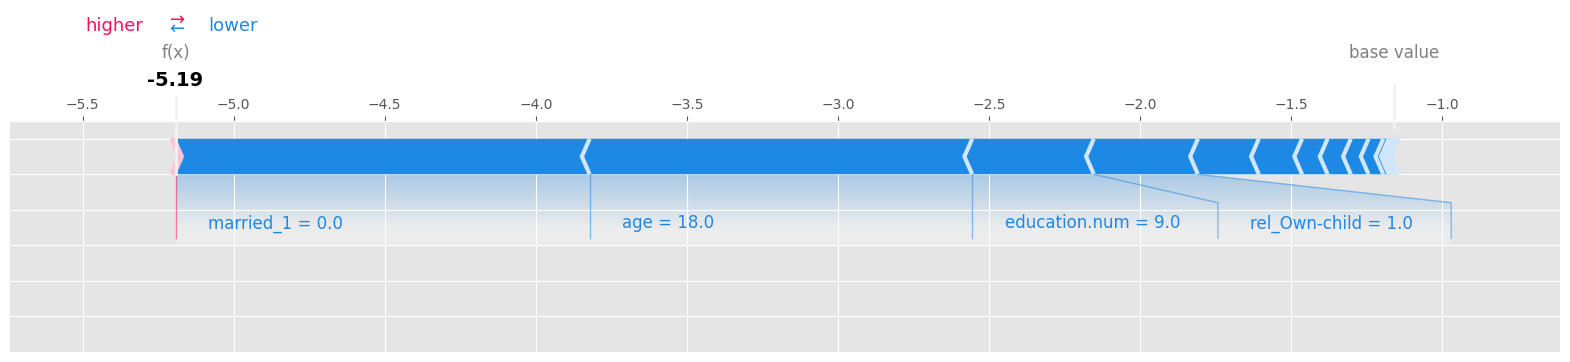

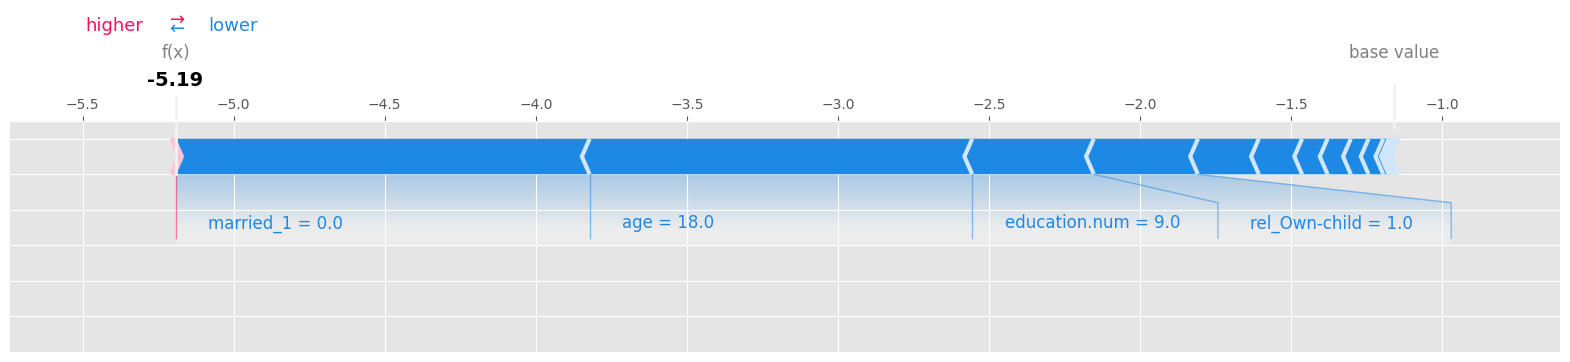

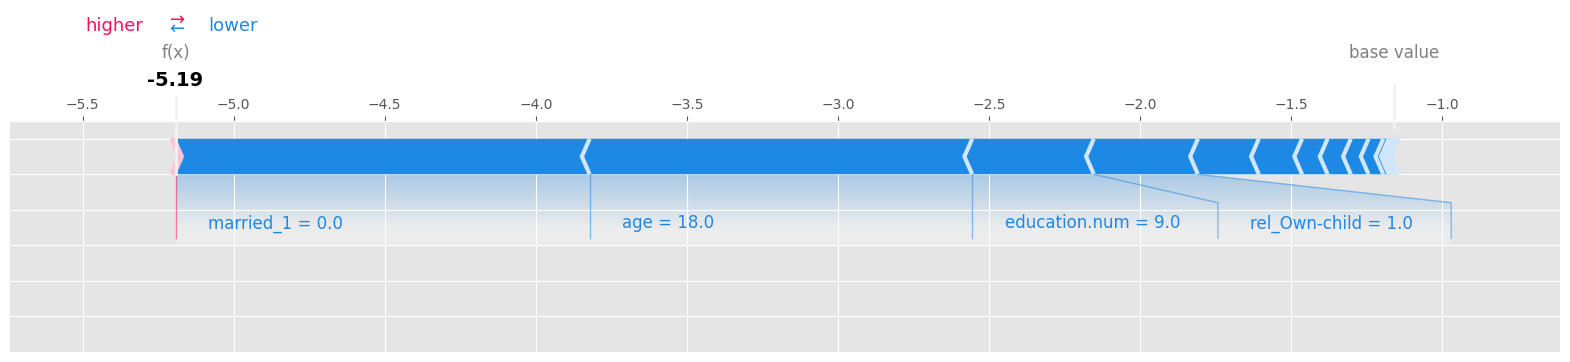

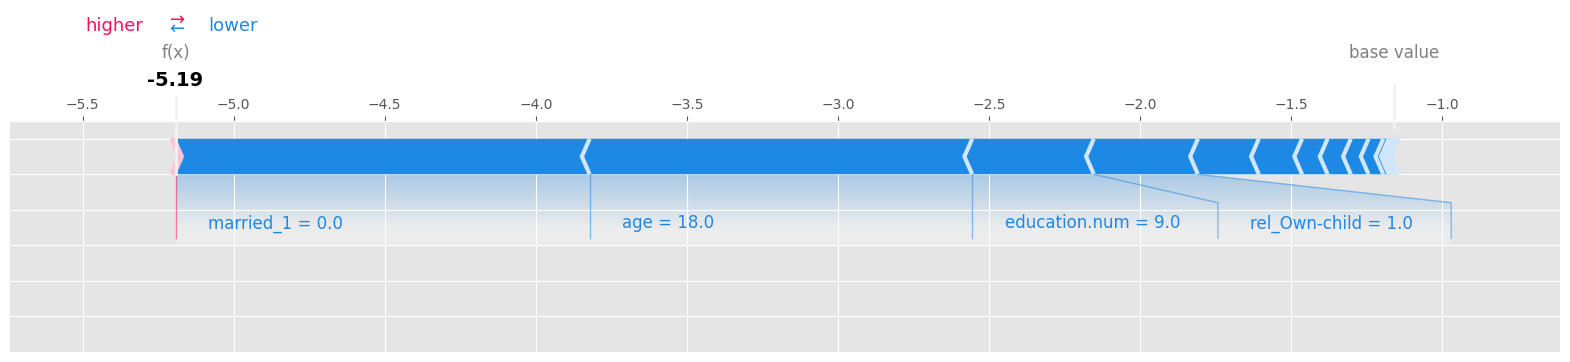

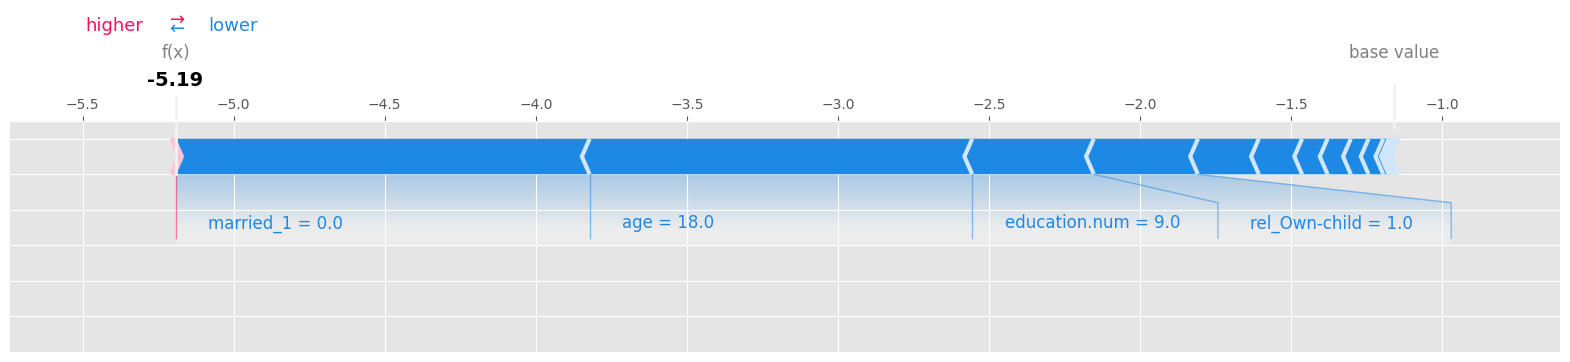

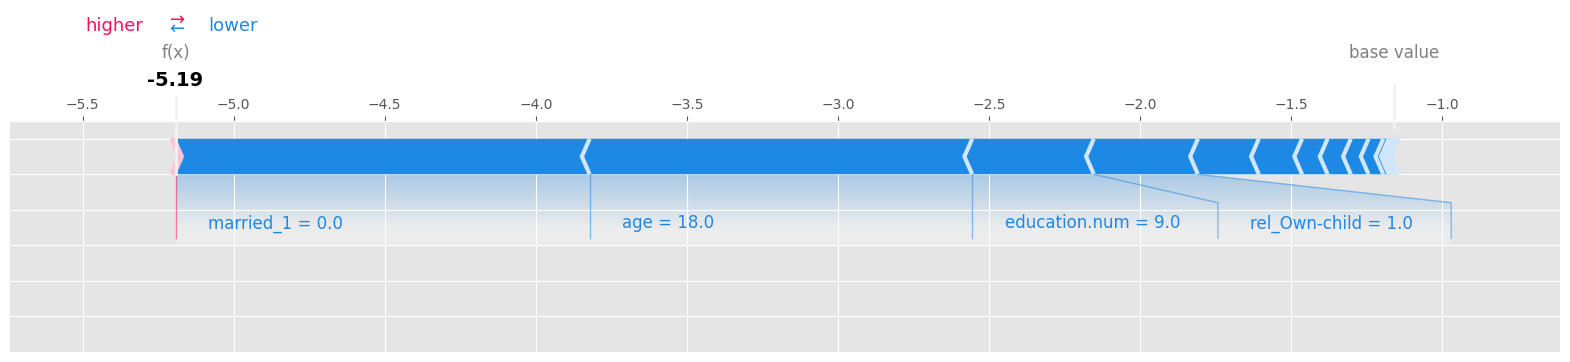

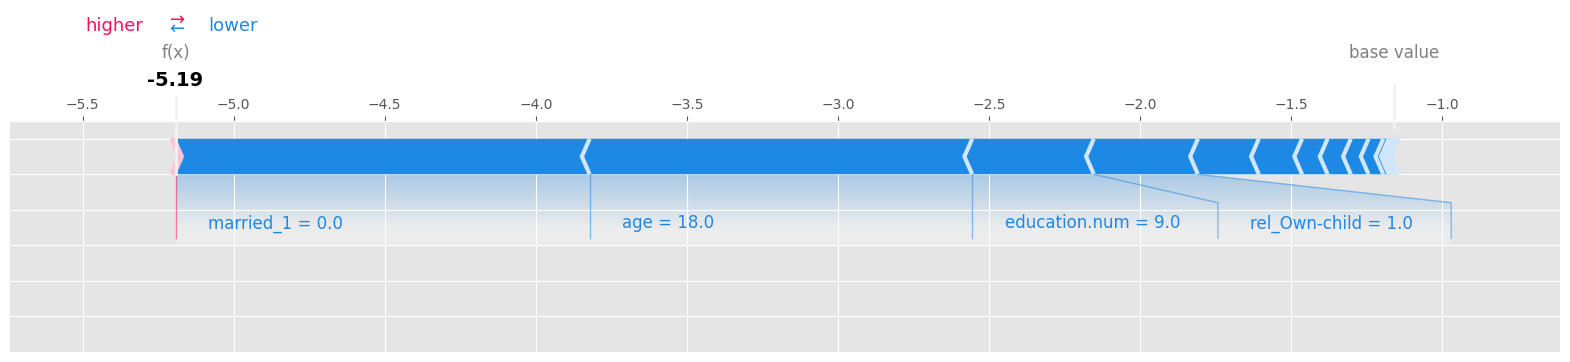

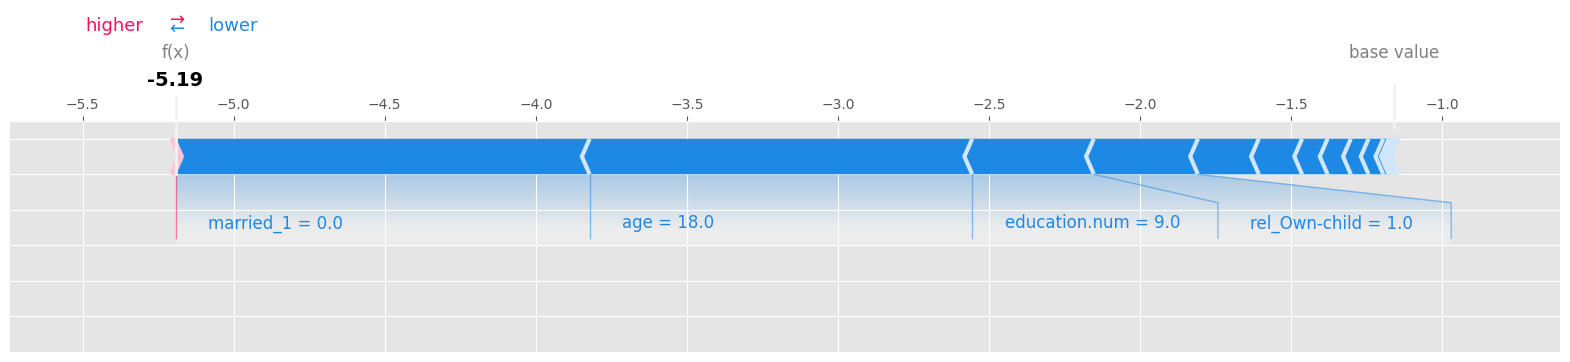

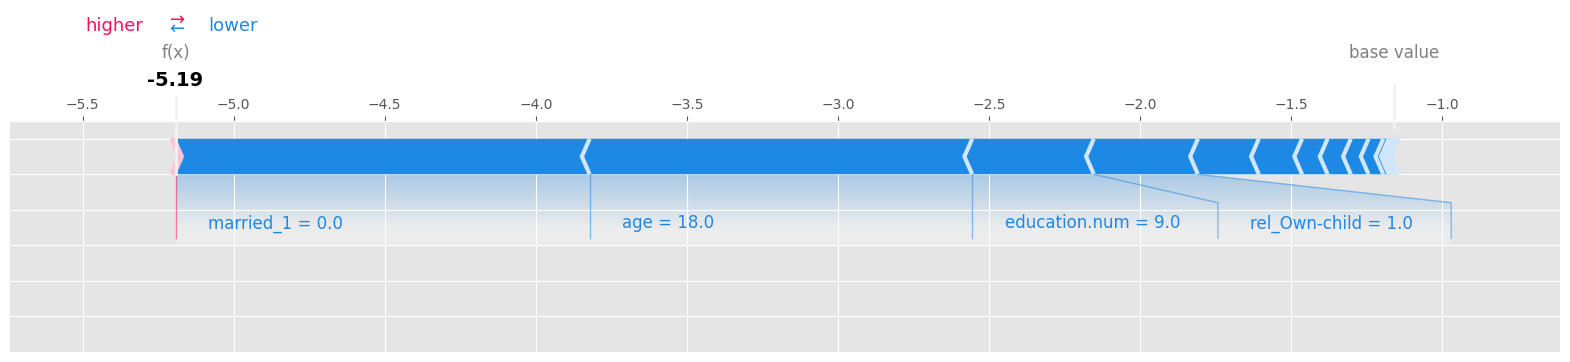

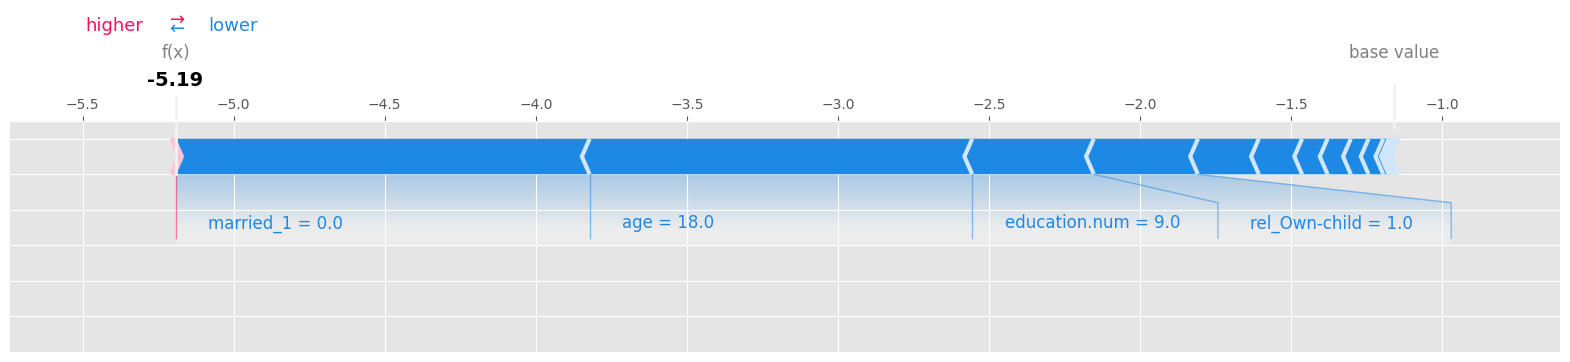

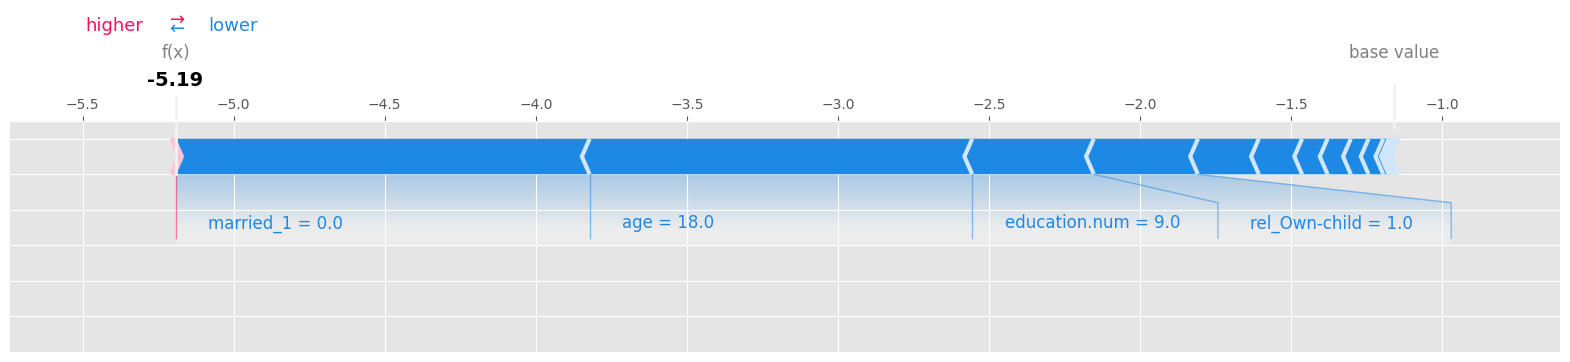

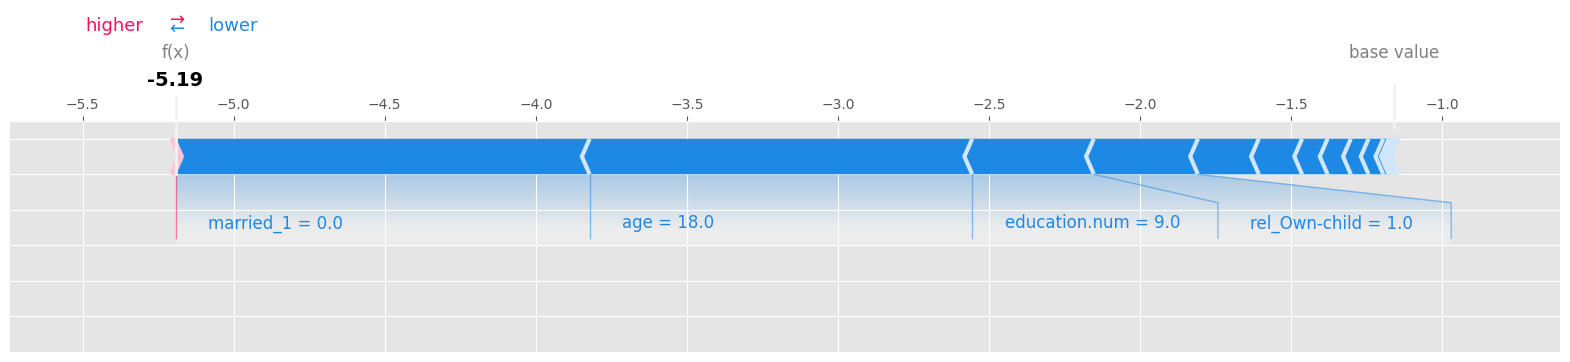

In [ ]:
import shap
import matplotlib.pyplot as plt


explainer = shap.Explainer(clf_xgb_array)

i = input("Give some instance (an integer from the domain): ")
i = int(i)

# Reshape the instance data to a 2D matrix
instance_data = X_test.iloc[i:i+1, :]

for _ in range(20):
    # Create SHAP values for the current instance
    shap_values = explainer.shap_values(instance_data)

    # Summary plot using force_plot for the specific instance
    shap.force_plot(explainer.expected_value, shap_values[0, :], instance_data, matplotlib=True, show=False)

    # Display the plot
    plt.show()


In [ ]:
# The mightly yet faulty SP LIME
sp_obj = submodular_pick.SubmodularPick(explainer, X_test.values, clf_xgb_array.predict_proba, sample_size=3, num_exps_desired=3)

[exp.show_in_notebook() for exp in sp_obj.sp_explanations]


[None, None, None]

In [ ]:
explainer = shap.TreeExplainer(clf_xgb_df, model_output='probability', feature_dependence='independent', data = X_test)


In [ ]:
row_to_show = 191
data_for_prediction = X_test.iloc[row_to_show, :]

shap_values = explainer.shap_values(data_for_prediction)
shap.initjs()

shap.force_plot(explainer.expected_value, shap_values, data_for_prediction)

ValueError: ignored

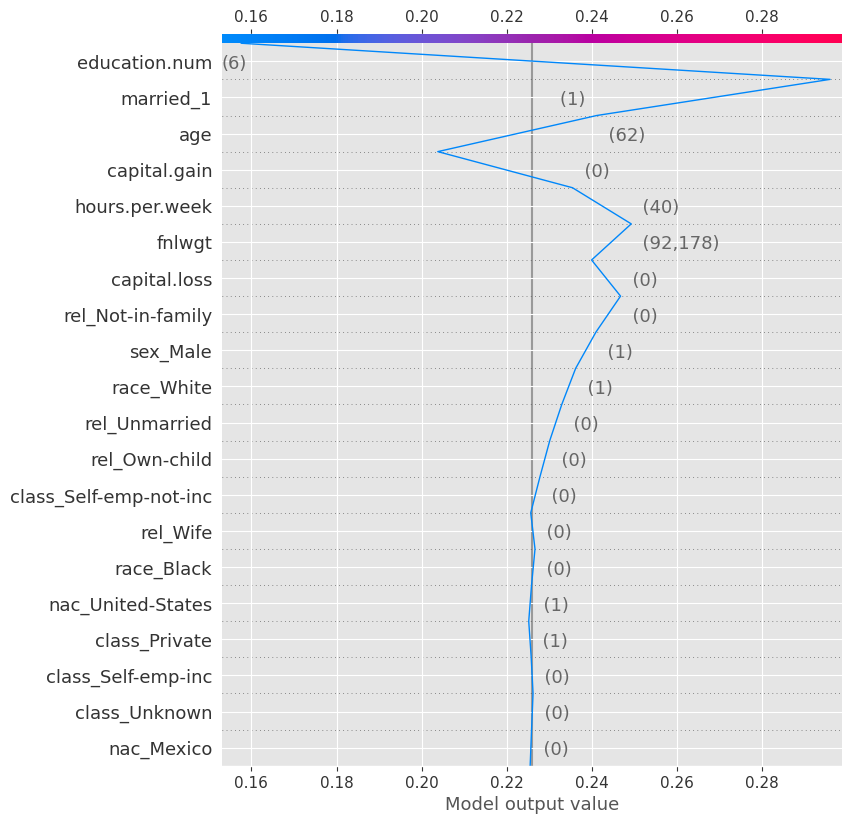

In [ ]:
shap.decision_plot(explainer.expected_value, shap_values, data_for_prediction)


Fairness Stuff

In [ ]:
importances, _ = audit_model(clf_xgb_array.predict, X_train, distance_metric="mse")


In [ ]:
importances_dict={i:np.mean(np.array(f).astype(np.float)) for i,f in importances.items()}
pd.DataFrame(importances_dict, index=['Importance']).transpose().sort_values(by='Importance', ascending=False)


Importance
education.num             0.188410
hours.per.week            0.188143
fnlwgt                    0.176192
married_1                 0.172854
nac_United-States         0.168380
...                            ...
rel_Not-in-family        -0.011884
class_Self-emp-not-inc   -0.014955
class_Local-gov          -0.017025
class_Private            -0.116304
age                      -0.188743

[66 rows x 1 columns]

from matplotlib import pyplot as plt
_df_12['Importance'].plot(kind='hist', bins=20, title='Importance')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_13['Importance'].plot(kind='line', figsize=(8, 4), title='Importance')
plt.gca().spines[['top', 'right']].set_visible(False)

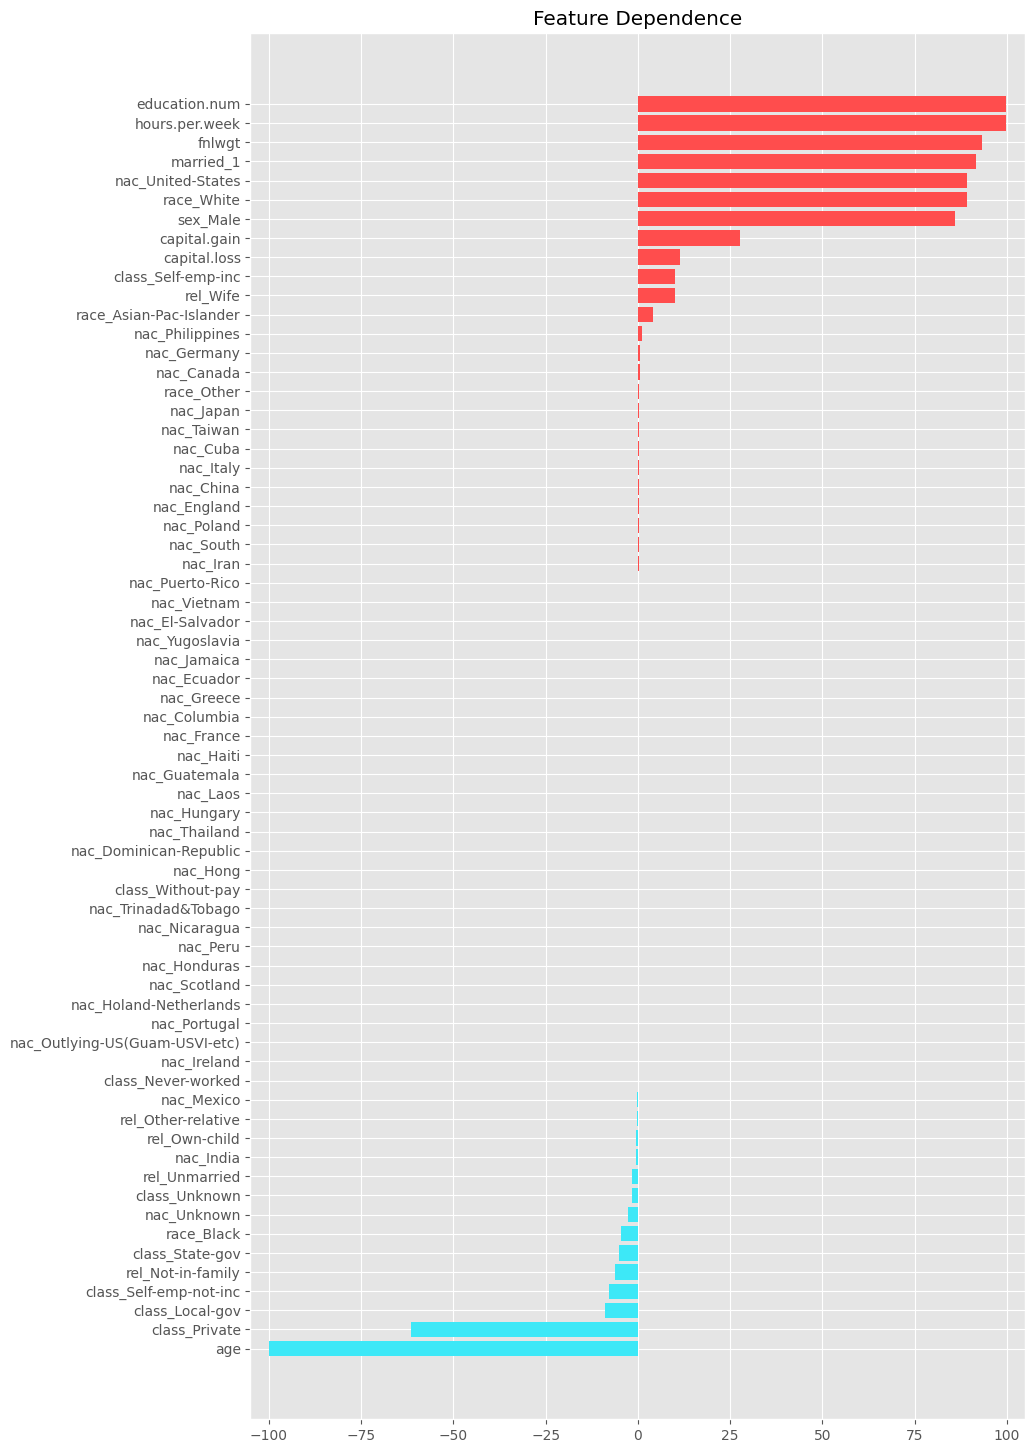

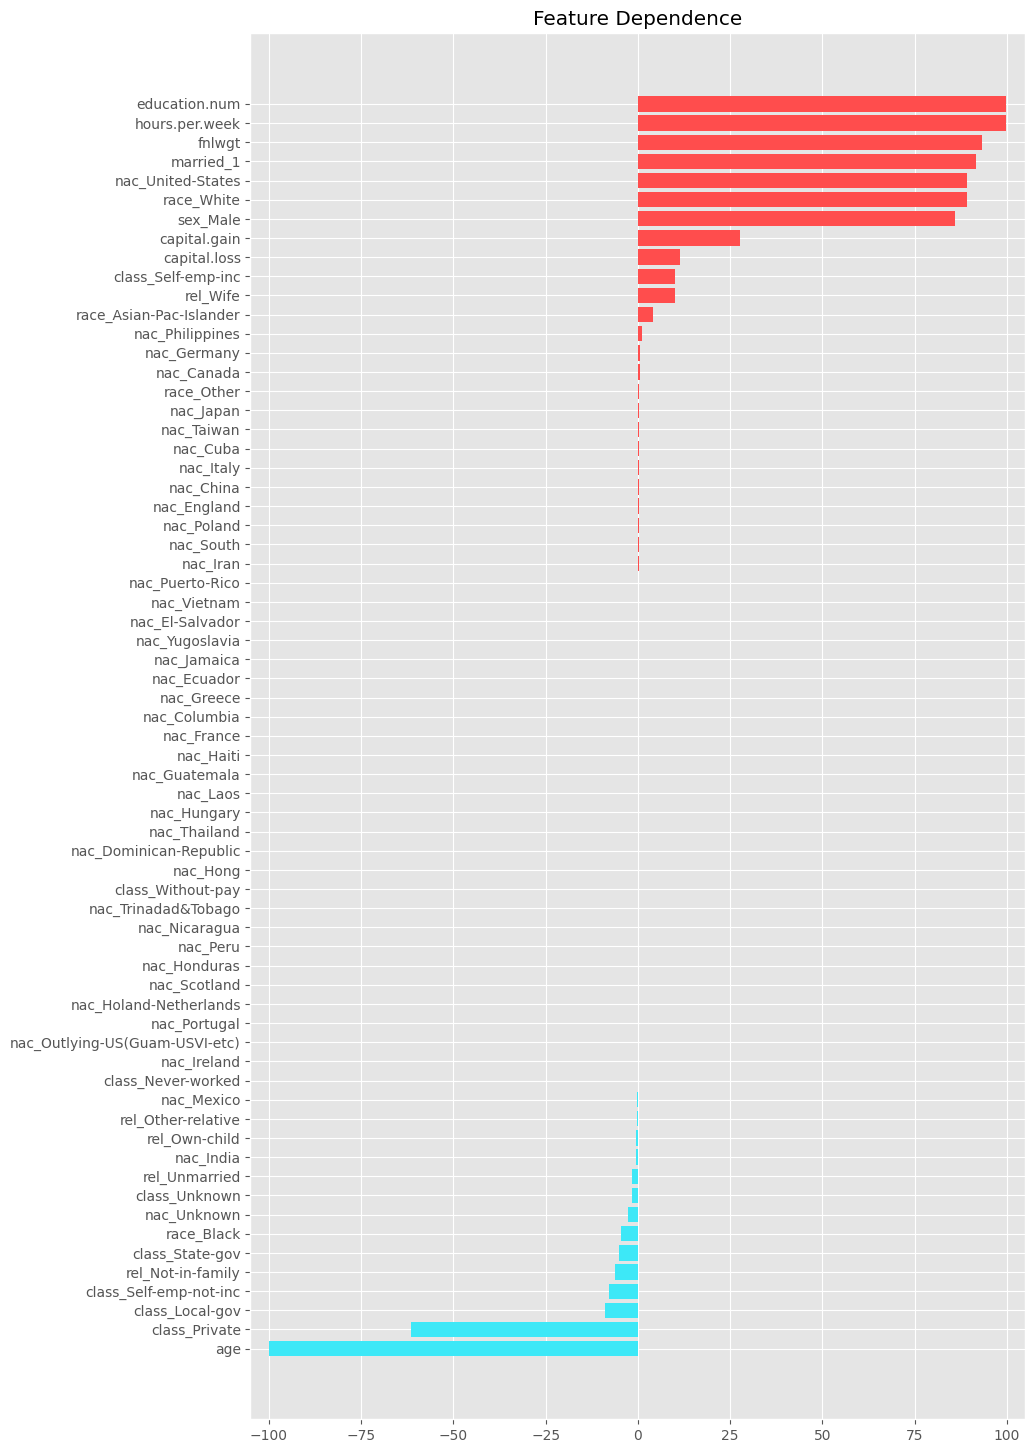

In [ ]:
plot_dependencies(
    importances.median(),
    reverse_values=False,
    title="Feature Dependence",
    fig_size=(10,18)
)